In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False
1,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.7829,2,5,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          321      0.5358 0.2534   0.7005 0.5231   0.5171
Totals (Over/Under)  321      0.4829 0.2504   0.6940 0.5125   0.5265
Asian Handicap       321      0.7664 0.1839   0.5560 0.5168   0.7632


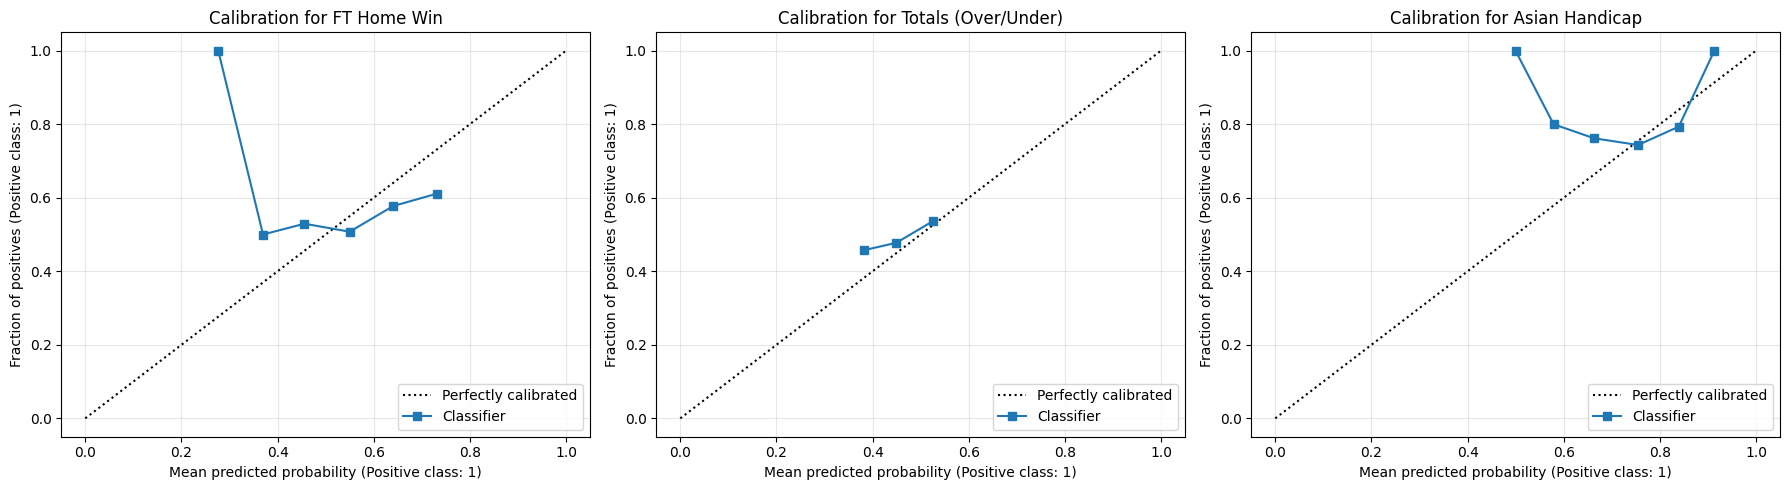

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=10)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          181      0.5414 0.2481   0.6888 0.5568   0.5138
Totals (Over/Under)  181      0.4917 0.2505   0.6941 0.5208   0.5028
Asian Handicap       181      0.7735 0.1835   0.5535 0.4924   0.7680


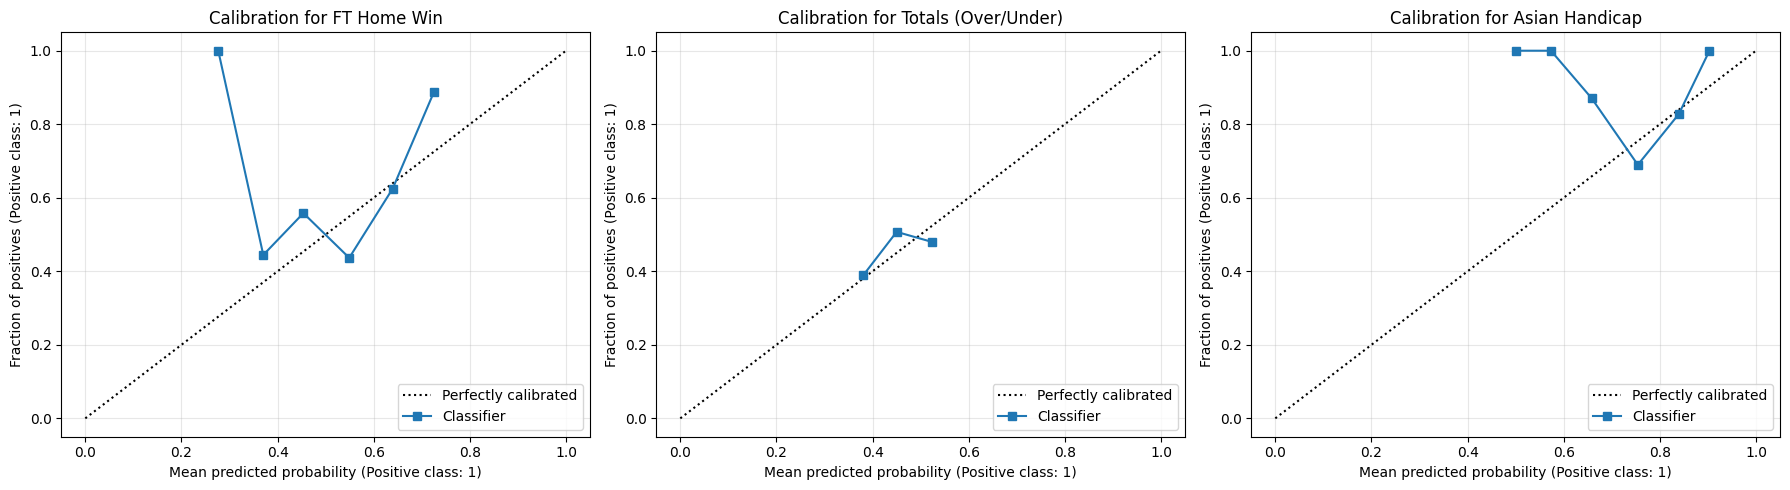

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=10)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500275,2025-11-23T18:00:00,Philadelphia 76ers,Miami Heat,0.4142,0.7270,0.6308,117,127,False,True,False


=== Evaluation Summary ===
                      n  prevalence  brier  logloss    auc  acc@0.5
metric                                                             
FT Home Win          51      0.5490 0.1956   0.5699 0.7624   0.6471
Totals (Over/Under)  51      0.6275 0.2446   0.6832 0.5214   0.5882
Asian Handicap       51      0.7647 0.1422   0.4363 0.8013   0.8235


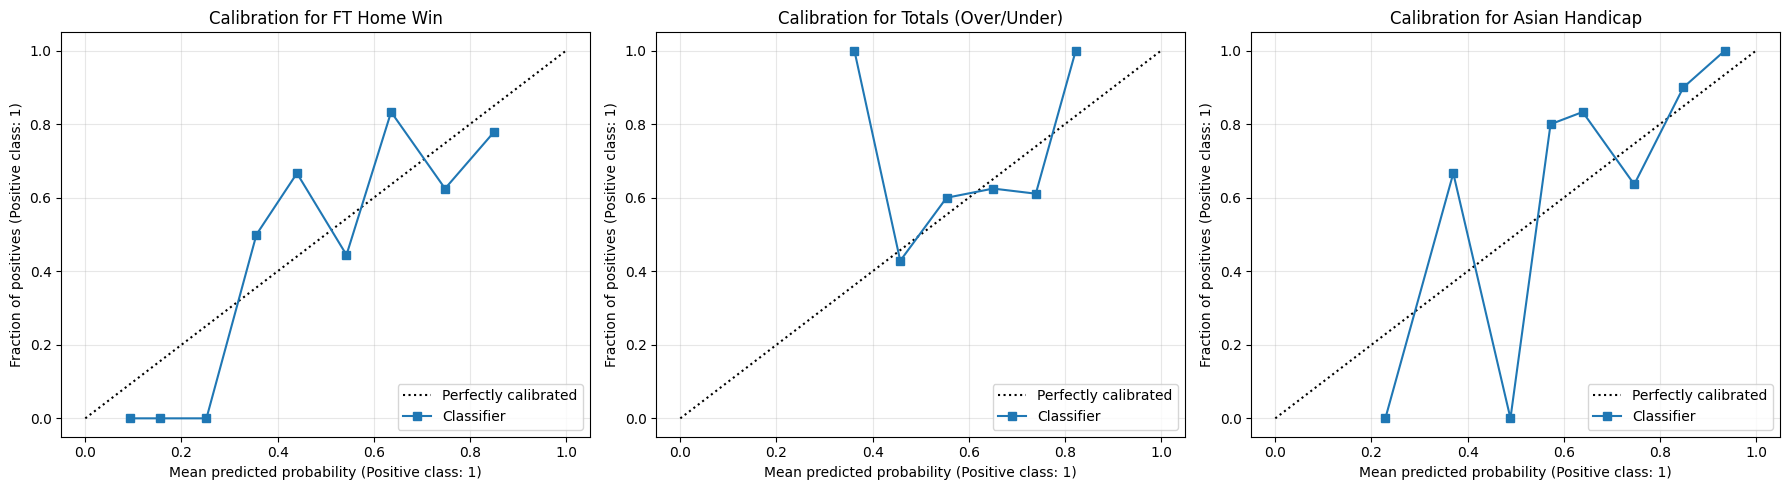

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=10)